## Optimizacion Industrial con Computacion Evolutiva - Proyecto Final
<b> Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial</b>

**Docentes:**
- Dr. Edwin Villanueva
- Mg. Irvin Vargas Campos

**Participantes:**
- Jorge Cabrera Dávila
- Carlos Casaño Arzapalo

## 1 Librerias

In [215]:
import sys
import os
import itertools
import time
import random
import math
import pandas            as     pd
import numpy             as     np
import matplotlib.pyplot as     plt
import seaborn           as     sns
import geopandas         as     gpd
from   shapely.geometry  import Point, Polygon
from   geopy.distance    import geodesic
from   random            import shuffle, random   , sample
from   random            import randint, randrange, uniform
from   copy              import deepcopy
from   IPython.display   import clear_output
from   tqdm              import tqdm

## 2 Funciones relacionadas a un individuo

#### 2.1 Define el objeto Item en el problema de la mochila
Un objeto de clase Item almacena erl valor del item y el peso del item

In [216]:
##=============================================================================
## DEFINICIÓN DEL ITEM OBJETIVO
   ## poblacion500m = Cantidad de habitntes a 500 metros a la redonda
##=============================================================================
class Item(object):
    def __init__(self, poblacion500m, latitud, longitud):
        self.poblacion500m  = poblacion500m
        self.latitud        = latitud
        self.longitud       = longitud

#### 2.2 Define la estructura de un individuo en el AG con sus operadores genéticos

Implementa el individuo del AG. Un individuo tiene un cromosoma que es una lista de NUM_ITEMS elementos (genes), cada gen i puede asumir dos posibles alelos: 0 o 1 (no incluir/incluir en la mochila el item i del pool)

In [217]:
##=============================================================================
## DEFINICIÓN DEL INDIVIDUO
##=============================================================================
    ##    El constructor __init__ recibe un cromosoma
    ##    Fitness = -1 indica que el individuo no ha sido evaluado
    ##=========================================================================
class Individual:

    def __init__(self, chromosome):
        self.chromosome = chromosome[:]
        self.fitness    = -1
    ## ========================================================================
    ## OPERADORES GENÉTICOS DE CRUZAMIENTO
    ## ========================================================================

         ## -------------------------------------------------------------------
         ##     Cruzamiento tipo "ONE POINT"
         ##     Retorna dos nuevos individuos del cruzamiento de un punto
         ##     entre individuos self y other
         ## -------------------------------------------------------------------
    def crossover_onepoint(self, other):
        c    = randrange(len(self.chromosome))
        ind1 = Individual(self.chromosome[:c]  + other.chromosome[c:])
        ind2 = Individual(other.chromosome[:c] + self.chromosome[c:])
        return [ind1, ind2]
        ## --------------------------------------------------------------------
        ##     Cruzamiento tipo "UNIFORM"
        ##     Retorna dos nuevos individuos del cruzamiento uniforme entre
        ##     self y other
        ## --------------------------------------------------------------------
    def crossover_uniform(self, other):
        chromosome1 = []
        chromosome2 = []
        for i in range(len(self.chromosome)):
            if uniform(0, 1) < 0.5:
                chromosome1.append(self.chromosome[i])
                chromosome2.append(other.chromosome[i])
            else:
                chromosome1.append(other.chromosome[i])
                chromosome2.append(self.chromosome[i])
        ind1 = Individual(chromosome1)
        ind2 = Individual(chromosome2)
        return [ind1, ind2]

        ## --------------------------------------------------------------------
        ##     Cruzamiento tipo "ORDERPERMUTATION"
        ## --------------------------------------------------------------------
    def crossover_orderpermutation(self, other):
        "Uniform order-based crossover. Genera 2 cromosomas hijos  que tambien deben ser permutaciones"
        "Retorna dos nuevos individuos del cruzamiento de permutacion entre self y other"
        "Escoge aleatoriamente la mitad de posiciones del cromosoma self y lo copia a un hijo ind1 en las mismas posiciones"
        "Los numeros faltantes los copia de other en el mismo orden en que aparecen en other "
        "El hijo ind2 se crea de la misma forma intercambiando self por other"

        pos_constantes = []
        pos_constantes = random.sample(range(len(self.chromosome)),len(self.chromosome)//2)
        cromosomo1 = [-1]*len(self.chromosome)
        cromosomo2 = [-1]*len(self.chromosome)

        for index in pos_constantes:
            cromosomo1[index]= self.chromosome[index]
            cromosomo2[index] = other.chromosome[index]


        for i in range(len(self.chromosome)):
            if(cromosomo1[i] == -1):
                for j in range(len(other.chromosome)):
                    if other.chromosome[j] not in cromosomo1:
                        cromosomo1[i] = other.chromosome[j]
                        break

                for j in range(len(self.chromosome)):
                    if self.chromosome[j] not in cromosomo2:
                        cromosomo2[i] = self.chromosome[j]
                        break

        ind1 = Individual(cromosomo1)
        ind2 = Individual(cromosomo2)
        return [ind1, ind2]

        ## --------------------------------------------------------------------
        ##     Cruzamiento tipo "ARITHMETIC"
        ## --------------------------------------------------------------------
    def crossover_arithmetic(self, other):
        """ Cruzamiento aritmetico completo de los cromosomas de self con other. Genera hijos:
            chromosome1 = alpha*self + (1−alpha)*other
            chromosome2 = alpha*other + (1−alpha)*self
        """
        #TO DO: Desarrollo su código
        chromosome1 = []
        chromosome2 = []
        alpha = random.random()
        #chromosome1.append(alpha*self[i]  + (1-alpha)*other[i] for i in range(len(self.chromosome)))
        #chromosome2.append(alpha*other[i] + (1-alpha)*self[i]  for i in range(len(self.chromosome)))
        for i in range(len(self.chromosome)):
            chromosome1.append(alpha*self.chromosome[i]  + (1-alpha)*other.chromosome[i])
            chromosome2.append(alpha*other.chromosome[i] + (1-alpha)*self.chromosome[i] )
        ind1 = Individual(chromosome1)
        ind2 = Individual(chromosome2)
        return [ind1, ind2]

    ## ========================================================================
    ## OPERADORES GENÉTICOS DE MUTACIÓN
    ## ========================================================================

        ## --------------------------------------------------------------------
        ##     Mutación tipo "FLIP"
        ##     Cambia aleatoriamente el alelo de un gen.
        ##     escoge un gen para mutar
        ## --------------------------------------------------------------------
    def mutation_flip(self):
        new_chromosome = deepcopy(self.chromosome)
        mutGene        = randrange(0,len(new_chromosome))
        if new_chromosome[mutGene] == 0:  new_chromosome[mutGene] = 1
        else                           :  new_chromosome[mutGene] = 0
        return Individual(new_chromosome)

       ## --------------------------------------------------------------------
       ##      Mutción tipo "SWAP"
       ## --------------------------------------------------------------------
    def mutate_swap(self):
        "Escoge dos genes e intercambia sus alelos"
        mutated_chromosome = deepcopy(self.chromosome[:])
        mutGen1 = random.randrange(1,len(mutated_chromosome))
        mutGen2 = random.randrange(1,len(mutated_chromosome))
        temp = mutated_chromosome[mutGen1]
        mutated_chromosome[mutGen1] = mutated_chromosome[mutGen2]
        mutated_chromosome[mutGen2] = temp
        return Individual(mutated_chromosome)

        ## --------------------------------------------------------------------
        ##     Mutación tipo "SINGLE GENE"
        ## --------------------------------------------------------------------
    def mutate_singlegene(self, intensity_mutation):
        """ Perturba un alelo (coordenada) de un gen (dimension) ."""
        mutated_chromosome = deepcopy(self.chromosome)
        mutGene = random.randrange(0,len(mutated_chromosome))
        newAllele = mutated_chromosome[mutGene] + random.uniform(-1,1) * intensity_mutation * mutated_chromosome[mutGene]
        mutated_chromosome[mutGene] = newAllele
        return Individual(mutated_chromosome)

        ## --------------------------------------------------------------------
        ##     Mutación tipo "ALL GENES"
        ## --------------------------------------------------------------------
    def mutate_allgenes(self, intensity_mutation):
        "Perturba todo el cromosoma sumando un vector aleatorio pequeño "
        module_chromosome = math.sqrt(sum(i**2 for i in self.chromosome))  # calcula el modulo del cromosoma
        perturbation_vector = [ module_chromosome * intensity_mutation * random.uniform(-1, 1) for j in range(len(self.chromosome))]
        mutated_chromosome =  [sum(x) for x in zip(*[self.chromosome, perturbation_vector])]  # suma el cromosoma con el vector perturbacion
        return Individual(mutated_chromosome)

In [218]:
## ============================================================================
## OPERADORES GENÉTICO DE SELECCIÓN DE SOBREVIVIENTES
## ============================================================================

    ## ------------------------------------------------------------------------
    ##        Selección tipo "RANKING"
    ## ------------------------------------------------------------------------
def select_survivors_ranking(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population)
    isurvivors = sorted(range(len(population)),
                        key=lambda i: population[i].fitness,
                        reverse=True)[:numsurvivors]
    for i in range(numsurvivors):
        next_population.append(population[isurvivors[i]])
    return next_population

#### 2.3 Funcion para obtener los fitnesses de un cromosoma

In [219]:
# suma las poblaciones de un cromosoma
def suma_poblaciones(ItemPool, chromosome):
    sumatoria = sum( [ItemPool[chromosome[i]].poblacion500m for i in range(len(chromosome))] )
    return sumatoria

In [220]:
# suma el total de distancias entres pares de puntos de un cromosoma
def suma_distancias(ItemPool, chromosome):
    x = [ItemPool[i].longitud for i in range(NUM_ITEMS) ]
    y = [ItemPool[i].latitud  for i in range(NUM_ITEMS) ]
    df_items = pd.DataFrame({'Latitud':y,'Longitud':x})
    puntos = pd.DataFrame(columns = df_items.columns)
    for i in chromosome:
        puntos.loc[len(puntos)] = [ItemPool[i].latitud, ItemPool[i].longitud]  #candidatos.loc[i]
    distancias = np.zeros((len(puntos), len(puntos)))
    suma = 0
    for i, j in list(itertools.product(puntos.index, puntos.index)):
        if i > j: suma += round( geodesic((puntos['Latitud'][i], puntos['Longitud'][i]),
                                          (puntos['Latitud'][j], puntos['Longitud'][j])).kilometers,2)
    return suma

In [221]:
# obtiene las distancias entre cada par de puntos del cromosoma
# para validar que se cumpla la limitación de la distancia menor a 1 Km.
def distancias_cromosoma(indices,ItemPool):
    x = [ItemPool[i].longitud for i in range(NUM_ITEMS) ]
    y = [ItemPool[i].latitud  for i in range(NUM_ITEMS) ]
    df_items = pd.DataFrame({'Latitud':y,'Longitud':x})
    puntos = pd.DataFrame(columns = df_items.columns)
    for i in indices:
        puntos.loc[len(puntos)] = [ItemPool[i].latitud, ItemPool[i].longitud]  #candidatos.loc[i]
    distancias = np.zeros((len(puntos), len(puntos)))
    for i, j in list(itertools.product(puntos.index, puntos.index)):
        if i > j: distancias[i][j] = round( geodesic((puntos['Latitud'][i], puntos['Longitud'][i]),
                                                     (puntos['Latitud'][j], puntos['Longitud'][j])).kilometers,2)
    # Aplanar el arreglo, eliminar ceros, duplicados y ordenar.
    minimos = np.sort(np.unique(distancias.flatten()[distancias.flatten() != 0]))
    return distancias, minimos[0]

In [222]:
##=============================================================================
## FUNCIÓN FITNESS MONO-OBJETIVO
##=============================================================================
    ## Retorna los fitness del cromosoma pasado como un valor decimal.
    ## Fitness es la combinación de la suma de pares de distancias del cromosoma
    ## y la suma de las poblaciones atendidas
    ## Si alguno de los pares de distancias dentre los puntos del cromosoma
    ## es menor a 1 Km => asigna al fitmess el valor de 1
    ## ========================================================================
def get_fitness_mono(chromosome, ItemPool, MIN_DISTANCIA):
    fitness, suma_poblacion, suma_distancia = 0.  , 0.   , 0.
    suma_poblacion  = suma_poblaciones(ItemPool, chromosome)/MAX_POBLACION  # Valor entre 0 y 1
    suma_distancia  = suma_distancias (ItemPool, chromosome)/MAX_DISTANCIA  # Valor entre 0 y 1
    arreglo, min    = distancias_cromosoma(chromosome,ItemPool)
    if min < MIN_DISTANCIA: fitness = 0
    else:                   fitness = math.sqrt((suma_poblacion)**2 + (suma_distancia)**2)
    return fitness

In [223]:
##=============================================================================
## FUNCIÓN FITNESS MULTIOBJETIVO
##=============================================================================
    ## Retorna los fitness del cromosoma pasado [valor_de_la_mochila, ligereza]
    ## fitness tiene 2 objetivos:
    ##         fitness[0] es suma de poblaciones
    ##         fitness[1] es suma de distancias
    ## ========================================================================
def get_fitness_mult(chromosome, ItemPool, MIN_DISTANCIA):
    fitness, sum_poblacion, sum_distancia = np.zeros(2), 0, 0
    sum_poblacion = suma_poblaciones(ItemPool, chromosome)
    sum_distancia = suma_distancias (ItemPool, chromosome)
    arreglo, min  = distancias_cromosoma(chromosome,ItemPool)

    # Asignar fitness
    if min < MIN_DISTANCIA: fitness[0], fitness[1] = 0, 0
    else:                   fitness[0], fitness[1] = sum_poblacion, sum_distancia

    return fitness

## 3 Funciones relacionados a la población

#### 3.1 Funcion para inicializar aleatoriamente una población de individuos

In [224]:
# calcula la distancia de cada punto con los demàs puntos de los 60 supermeracos
# candidatos, asigna 0 si la distancia es menor a 1 Km., caso contrario asigna 1
def calcular_distancias(candidatos):
    distancias = np.zeros((len(candidatos), len(candidatos)))
    for i in range(len(candidatos)):
        for j in range(len(candidatos)):
            linea = round( geodesic((candidatos['Latitud'][i], candidatos['Longitud'][i]),
                                    (candidatos['Latitud'][j], candidatos['Longitud'][j])).kilometers,2)
            if linea < 1: distancias[i][j] = 0
            else:         distancias[i][j] = 1
    return distancias

In [225]:
## =========================================================
## INICIALIZACIÓN DE LA POBLACIÓN VALIDANDO DISTANCA MÍNIMA
## =========================================================
    ##   POP_SIZE        = poblacion, cantidad de individuos
    ##   CHROMOSOME_SIZE = cantidad de genes del cromosoma
    ## =====================================================
def init_population(POP_SIZE, CHROMOSOME_SIZE, candidatos):
    population = []
    distancias_uno = calcular_distancias(candidatos)
    for k in range(POP_SIZE):
        interseccion    = np.ones(60,dtype= int)
        nuevo_cromosoma = np.zeros(10,dtype= int)
        for i in range(CHROMOSOME_SIZE):
            # seleccionar de los puntos con distacias mayores a 1 km (valor = 1)
            indices_unos       = [n for n, valor in enumerate(interseccion) if valor == 1]

            # seleccionar un punto aleatoriamente
            indice             = random.choice(indices_unos)

            # asigna el indice al gen del nuevo cromosoma
            nuevo_cromosoma[i] = indice

            # interseccion de los puntos con distancias menores a 1 Km.
            # con las distancias menores a 1 Km del indice seleccionado.
            for j in range(len(interseccion)):
                interseccion[j] = int(distancias_uno[indice][j] * interseccion[j])
        population.append( Individual( nuevo_cromosoma ) )
    return population

#### 3.2 Función para evaluar la población de individuos

In [226]:
## ============================================================================
## EVALUAR LA POBLACIÓN MONO-OBJETIVO
## ============================================================================
    ## Evalua una poblacion de individuos con la funcion get_fitness_mono
    ##   pop_size        = poblacion, cantidad de individuos
    ##   chromosome_size = cantidad de genes del cromosoma
    ## ========================================================================
def evaluate_population_mono(population, ItemPool, MIN_DISTANCIA):
    pop_size = len(population)

    for i in range(pop_size):
        if population[i].fitness == -1:    # evalua solo si el individuo no esta evaluado
           population[i].fitness = get_fitness_mono(population[i].chromosome, ItemPool, MIN_DISTANCIA)

In [206]:
## ============================================================================
## EVALUAR LA POBLACIÓN MULTIOBJETIVO
## ============================================================================
    ## Evalua una poblacion de individuos con la funcion get_fitness_mult
    ##   pop_size        = poblacion, cantidad de individuos
    ##   chromosome_size = cantidad de genes del cromosoma
    ## ========================================================================
def evaluate_population_mult(population, ItemPool, MIN_DISTANCIA):
    for i in range(len(population)):
        if population[i].fitness == -1:    # evalua solo si el individuo no esta evaluado
           population[i].fitness = get_fitness_mult(population[i].chromosome, ItemPool, MIN_DISTANCIA)

#### 3.3 Función: build_offspring_population

In [227]:
def build_offspring_population(population, crossover, mutation, pmut, intensity_mut=0.5):
    """ Construye una poblacion hija con los operadores de cruzamiento y mutacion
        crossover:  operador de cruzamiento
        mutation:   operador de mutacion
        pmut:       taza de mutacion
    """
    pop_size = len(population)

    #======================================================================
    ## ETAPA 3: SELECCIONAR INDIVIDUOS MÁS APTOS (MÉTODO ALEATORIO)
    ## Selecciona parejas de individuos (mating_pool) para cruzamiento
    #======================================================================
    mating_pool = []
    for i in range(int(pop_size/2)):
        permut = np.random.permutation( pop_size )
        mating_pool.append( (population[permut[0]], population[permut[1]] ) )

    #======================================================================
    ## ETAPA 4: CRUZAMIENTO
    ## Crea la poblacion descendencia cruzando las parejas del mating pool
    #======================================================================
    offspring_population = []
    for i in range(len(mating_pool)):
        if crossover == "orderpermutation":
            offspring_population.extend( mating_pool[i][0].crossover_orderpermutation(mating_pool[i][1]) )
        elif crossover == "onepoint":
            offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) )
        elif crossover == "arithmetic":
            offspring_population.extend( mating_pool[i][0].crossover_arithmetic(mating_pool[i][1]) )
        elif crossover == "uniform":
            offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) )
        else:
            raise NotImplementedError

    #======================================================================
    ## ETAPA 5: MUTACIÓN
    ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
    #======================================================================
    for i in range(len(offspring_population)):
        if uniform(0, 1) < pmut:
            if mutation == "flip":
                offspring_population[i] = offspring_population[i].mutation_flip()
            elif mutation == "swap":
                offspring_population[i] = offspring_population[i].mutate_swap()
            elif mutation == "singlegene":
                offspring_population[i] = offspring_population[i].mutate_singlegene(intensity_mut)
            elif mutation == "allgenes":
                offspring_population[i] = offspring_population[i].mutate_allgenes(intensity_mut)
            else:
                raise NotImplementedError

    return offspring_population

#### 3.4 Función: get_crowding_distances

In [228]:
def get_crowding_distances(fitnesses):
    """
    La distancia crowding de un individuo es la diferencia del fitness mas proximo hacia arriba menos el fitness mas proximo
    hacia abajo. El valor crowding total es la suma de todas las distancias crowdings para todos los fitness
    """
    pop_size        = len(fitnesses[:, 0])
    num_objectives  = len(fitnesses[0, :])

    # crea matriz crowding. Filas representan individuos, columnas representan objectives
    crowding_matrix = np.zeros((pop_size, num_objectives))

    # normalisa los fitnesses entre 0 y 1 (ptp es max - min)
    normalized_fitnesses = (fitnesses - fitnesses.min(0)) / fitnesses.ptp(0)

    for col in range(num_objectives):   # Por cada objective
        crowding = np.zeros(pop_size)

        # puntos extremos tienen maximo crowding
        crowding[0] = 1
        crowding[pop_size - 1] = 1

        # ordena los fitness normalizados del objectivo actual
        sorted_fitnesses = np.sort(normalized_fitnesses[:, col])
        sorted_fitnesses_index = np.argsort(normalized_fitnesses[:, col])

        # Calcula la distancia crowding de cada individuo como la diferencia de score de los vecinos
        crowding[1:pop_size - 1] = (sorted_fitnesses[2:pop_size] - sorted_fitnesses[0:pop_size - 2])

        # obtiene el ordenamiento original
        re_sort_order = np.argsort(sorted_fitnesses_index)
        sorted_crowding = crowding[re_sort_order]

        # Salva las distancias crowdingpara el objetivo que se esta iterando
        crowding_matrix[:, col] = sorted_crowding

    # Obtiene las distancias crowding finales sumando las distancias crowding de cada objetivo
    crowding_distances = np.sum(crowding_matrix, axis=1)

    return crowding_distances

#### 3.5 Función: select_by_crowding

In [229]:
def select_by_crowding(population, num_individuals):
    """
    Selecciona una poblacion de individuos basado en torneos de pares de individuos: dos individuos se escoge al azar
    y se selecciona el mejor segun la distancia crowding. Se repite hasta obtener num_individuals individuos
    """
    population = deepcopy(population)
    pop_size   = len(population)

    num_objectives = len(population[0].fitness)

    # extrae los fitness de la poblacion en la matriz fitnesses
    fitnesses = np.zeros([pop_size, num_objectives])
    for i in range(pop_size): fitnesses[i,:] = population[i].fitness

    # obtiene las  distancias  crowding
    crowding_distances  = get_crowding_distances(fitnesses)

    population_selected = []   # poblacion escogida

    for i in range(num_individuals):  # por cada individuo a seleccionar

        # escoje dos individuos aleatoriamente de la poblacion no escogida aun
        permut  = np.random.permutation( len(population) )
        ind1_id = permut[0]
        ind2_id = permut[1]

        # Si ind1_id es el mejor
        if crowding_distances[ind1_id] >= crowding_distances[ind2_id]:

            # traslada el individuo ind1 de population a la lista de individuos seleccionados
            population_selected.append( population.pop(ind1_id) )
            # remueve la distancia crowding del individuo seleccionado
            crowding_distances = np.delete(crowding_distances, ind1_id, axis=0)

        else:  # Si ind2_id es el mejor

            # traslada el individuo ind2 de population a la lista de individuos seleccionados
            population_selected.append( population.pop(ind2_id) )
            # remueve la distancia crowding del individuo seleccionado
            crowding_distances = np.delete(crowding_distances, ind2_id, axis=0)

    return (population_selected)

#### 3.6 Función: get_paretofront_population

In [230]:
def get_paretofront_population(population):
    """
    Obtiene de population la poblacion de individups de la frontera de Pareto,
    """
    population = deepcopy(population)
    pop_size   = len(population)

    # todos los individuos son inicialmente asumidos como la frontera de Pareto
    pareto_front = np.ones(pop_size, dtype=bool)

    for i in range(pop_size): # Compara cada individuo contra todos los demas
        for j in range(pop_size):
            # Chequea si individuo 'i' es dominado por individuo 'j'
            #if all(population[j].fitness >= population[i].fitness) and any(population[j].fitness > population[i].fitness):
            #if str(all(population[j].fitness >= population[i].fitness)) and str(any(population[j].fitness > population[i].fitness)):
            if all(np.asarray(population[j].fitness) >= np.asarray(population[i].fitness)) and any(np.asarray(population[j].fitness) > np.asarray(population[i].fitness)):
                # j domina i -> señaliza que individuo 'i' como no siendo parte de la frontera de Pareto
                pareto_front[i] = 0
                break   # Para la busqueda para 'i' (no es necesario hacer mas comparaciones)

    paretofront_population = []
    for i in range(pop_size):  # construye la lista de individuos de la frontera de Pareto
        if pareto_front[i] == 1: paretofront_population.append(population[i])

    return paretofront_population

#### 3.7 Función: build_next_population

In [231]:
def build_next_population(population, min_pop_size, max_pop_size):
    """
    Construye la poblacion de la siguiente generacion añadiendo sucesivas fronteras de Pareto hasta
    tener una poblacion de al menos min_pop_size individuos. Reduce la frontera de Pareto con el metodo de
    crowding distance si al agregar la frontera excede el tamaño maximo de la poblacion (max_pop_size)
    """
    population      = deepcopy(population)
    pareto_front    = []
    next_population = []

    while len(next_population) < min_pop_size:   # mientras la poblacion no tenga el tamaño minimo
        # obtiene la poblacion frontera de Pareto actual
        paretofront_population = get_paretofront_population(population)

        # si poblacion actual + paretofront excede el maximo permitido -> reduce paretofront con el metodo de crowding
        combined_population_size = len(next_population) + len(paretofront_population)
        if  combined_population_size > max_pop_size:
            paretofront_population = select_by_crowding( paretofront_population, max_pop_size-len(next_population) )

        # Adiciona la frontera de Pareto (original o reducida) a la poblacion en construccion
        next_population.extend( paretofront_population )

        # remueve de population los individuos que fueron agregados a next_population
        for i in range( len(paretofront_population) ):
            for j in range( len(population) ):
                if all( np.asarray(paretofront_population[i].chromosome) == np.asarray(population[j].chromosome) ):
                    del(population[j])
                    break

    return next_population

#### 3.8 Función para graficar

In [347]:
def listar_items(pool):
    lista_values  = (pool[i].value  for i in range(0,len(pool)) )
    lista_weights = (pool[i].weight for i in range(0,len(pool)) )
    df = pd.DataFrame({'Value': lista_values,'Weight': lista_weights})
    df.reset_index(inplace = True)
    df.rename(columns={'index':'Item'}, inplace = True)
    return df.head(len(pool))

def datos_xy(poblacion, normaliza = True):
    pop_size       = len(poblacion)
    num_objectives = len(poblacion[0].fitness)
    fitnesses      = np.zeros([pop_size, num_objectives])
    for i in range(pop_size): fitnesses[i,:] = poblacion[i].fitness
    if normaliza == True:
        y = fitnesses[:, 1]/MAX_DISTANCIA
        x = fitnesses[:, 0]/MAX_POBLACION
    else                :
        y = fitnesses[:, 1]
        x = fitnesses[:, 0]
    return x, y, fitnesses

def graficar(poblacion0,title0,xlabel0,ylabel0,color0,poblacion1,title1,xlabel1,ylabel1,color1):
    x0, y0, fitnesses0 = datos_xy(poblacion0, normaliza = False)
    x1, y1, fitnesses1 = datos_xy(poblacion1, normaliza = True )

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle('')

    configurar_grafica(axs[0], title0,xlabel0,ylabel0)
    axs[0].scatter(x0, y0, color=color0, s=2)

    configurar_grafica(axs[1], title1,xlabel1,ylabel1)
    axs[1].scatter(x1, y1, color=color1, s=2)

    display(fig)
    clear_output(wait = True)
    plt.pause(0.1)

def graficar_poblacionx1(poblacion0,iter:int,bestfitness):
    x0 = [i for i in range(len(poblacion0))]
    y0 = [poblacion0[i].fitness for i in range(len(poblacion0))]

    x1 = [i for i in range(iter+1)]
    y1 = bestfitness

    fig, axs = plt.subplots(1, 2, figsize=(20, 4))
    fig.suptitle('Generacion {} de {}'.format(str(iter), GENERATIONS))
    configurar_grafica(axs[0],
                       title='Fitness por individuo'+'\n' + 'BetsFitness = ' + str(round(max(y0),4)), ##Población ('+str(len(poblacion0))+')',
                       xlabel='Individuos',
                       ylabel='Fitnes-Valor')
    configurar_grafica(axs[1],
                       title='Bestfitnes por Generación'+'\n' + 'BetsFitness = ' + str(round(max(bestfitness),4)), # ('+str(len(poblacion0))+')',
                       xlabel='Generación',
                       ylabel='Best Fitnes')

    axs[0].scatter   (x0, y0, color='blue', s=2)
    axs[0].set_xlim(-1,POP_SIZE)
    axs[0].set_ylim(0,1.4)

    axs[1].set_xlim(-1,GENERATIONS)
    axs[1].set_ylim(0,1.4)
    axs[1].plot(x1, y1, color='red')

    display(fig)
    clear_output(wait = True)
    plt.pause(0.1)

def configurar_grafica(axs, title, xlabel, ylabel):
    axs.set_title(title)
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.grid(linestyle='dotted', linewidth=1)

def graficar_poblacionx2(poblacion0,poblacion1,poblacion2,poblacion3,iter:int):
    x0, y0, fitnesses0 = datos_xy(poblacion0)    # población de padres
    x1, y1, fitnesses1 = datos_xy(poblacion1)    # población de hijos
    x2, y2, fitnesses2 = datos_xy(poblacion2)    # población de frontera de Pareto
    x3, y3, fitnesses3 = datos_xy(poblacion3)    # población final
    fitnesses2_sorted  = fitnesses2[fitnesses2[:,0].argsort()]  ## frontera de Pareto ##
    x2s, y2s = fitnesses2_sorted[:, 0], 1/fitnesses2_sorted[:, 1]

    fig, axs = plt.subplots(1, 2, figsize=(20, 4))
    fig.suptitle('Generacion {} de {}'.format(str(iter), GENERATIONS))

    configurar_grafica(axs[0], title='AG Padre('+str(len(poblacion0)) +') / Hijos('+str(len(poblacion1)) +') / Pareto('+ str(len(poblacion2))+')',
                       xlabel='Objectivo A - Maximar valor ($)',
                       ylabel='Objectivo B - Minimizar peso (Kg)')
    axs[0].scatter   (x0, y0, color='blue', s=2)                # padres
    axs[0].scatter   (x1, y1, color='red' , s=2)                # hijos
    axs[0].plot(x2s,y2s,color='orange')

    configurar_grafica(axs[1], title='AG Población final('+str(len(poblacion3)) +') / Pareto('+str(len(poblacion2)),
                       xlabel='Objectivo A - Maximar valor ($)',
                       ylabel='Objectivo B - Minimizar peso (Kg)')
    axs[1].scatter   (x3, y3, color='blue', s=2)
    axs[1].plot(x2s,y2s, color='orange')

    display(fig)
    clear_output(wait = True)
    plt.pause(0.1)

# Graficos para algoritmo mono-objetivo
def graficar_poblacionx3(poblacion0,bestfitness,iter:int,pmut, ciclo):
    fig, axs = plt.subplots(1, 2, figsize=(20, 4))

    plt.figtext(0.5, 0.95, 'Ciclo '+ str(ciclo), ha = "center",
                bbox = {'facecolor': 'oldlace', 'alpha': 0.5, 'pad': 8})

    #plt.title('Generacion {} de {}'.format(str(iter), GENERATIONS))

    x0 = [i for i in range(len(poblacion0))]
    y0 = [poblacion0[i].fitness for i in range(len(poblacion0))]

    x1 = [i for i in range(iter+1)]
    y1 = bestfitness

    ibest = sorted(range(len(bestfitness)), key=lambda i: bestfitness[i] , reverse=True)
    configurar_grafica(axs[0],
                       title='Fitness por individuo (mono-objetivo)'+'\n'
                       + 'BetsFitness= ' + str(round(bestfitness[ibest[0]],4)), # +'\n'
                       xlabel='Individuos',
                       ylabel='Fitnes-Valor')
    configurar_grafica(axs[1],
                       title='Bestfitness por Generación (mono-objetivo)' +'\n'
                       + 'BetsFitness = ' + str(round(max(bestfitness),4)),
                       xlabel='Generación',
                       ylabel='Best Fitnes')
    axs[0].scatter   (x0, y0, color='blue', s=2)
    axs[0].set_xlim(-1,POP_SIZE)
    axs[0].set_ylim(0,1.4)

    axs[1].set_xlim(-1,GENERATIONS)
    axs[1].set_ylim(0,1.4)
    axs[1].plot(x1, y1, color='red')

    fig.show()
    #display(fig)
    #clear_output(wait = True)
    #plt.pause(0.1)

# Graficos para algoritmo multiobjetivo
def graficar_poblacionx4(betsfitness_mono, poblacion2,poblacion3,iter:int,pmut,ciclo):
    # poblacion2 = población sobre la Curva de Pareto
    # poblacion3 = población multiobjetivo
    fig, axs = plt.subplots(figsize=(10, 4))

    plt.figtext(0.25, 0.95, 'Ciclo '+ str(ciclo), ha = "center",
                bbox = {'facecolor': 'oldlace', 'alpha': 0.5, 'pad': 8})

    #plt.title('Generacion {} de {}'.format(str(iter), GENERATIONS))

    # Gráfico para algoritmo multiobjetivo
    x2, y2, fitnesses2 = datos_xy(poblacion2, normaliza = False)    # población de frontera de Pareto
    x3, y3, fitnesses3 = datos_xy(poblacion3, normaliza = False)    # población final
    fitnesses2_sorted  = fitnesses2[fitnesses2[:,0].argsort()]  ## frontera de Pareto ##
    x2s, y2s = fitnesses2_sorted[:, 0], fitnesses2_sorted[:, 1]

    ## Punto betfitness del algoritmo mono-objetivo
    cromosoma = bestfitness_mono.chromosome
    suma_poblacion  = suma_poblaciones(ItemPool, cromosoma)
    suma_distancia  = suma_distancias (ItemPool, cromosoma)
    #arreglo, min    = distancias_cromosoma(cromosoma,ItemPool)
    #suma_poblacion, suma_distancia
    x4 = suma_poblacion
    y4 = suma_distancia

    configurar_grafica(axs, title='Fitness Multiobjetivo' +'\n Frontera de Pareto',
                       xlabel='Objectivo A - Maximar suma de población (hab)',
                       ylabel='Objectivo B - Maximizar suma de distancias (Km)')
    ##axs[0].set_xlim(-1,2000)
    ##axs[0].set_ylim(0,2100)
    axs.scatter (x3 , y3, color='blue'  , s=5 )
    axs.plot    (x2s,y2s, color='orange'      )
    axs.scatter (x4 , y4, color='red'   , s=30)

    #plt.axhline(MAX_WEIGHT, color='blue')

    #axs[2].text(100, 610, 'Peso máximo = '+ str(MAX_WEIGHT), color = "blue", fontsize = 12 )
    #axs[1].axis('off')

    nota = plt.annotate(r'Mejor individuo mono-objetivo',
         xy=(x4, y4),
         xycoords='data',
         xytext=(135000, 350),
         fontsize=12,
         color = "red",
         textcoords='data',
         arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

    fig.show()
    #display(fig)
    #clear_output(wait = True)
    #plt.pause(0.1)

def busca_indice_bestfitness(P_mono):
    ibest = sorted(range(len(P_mono)), key=lambda i: P_mono[i].fitness, reverse=True)
    return ibest[0]

## 4 Inicialización

### 4.1 Parámetros

In [233]:
!git clone https://github.com/carloscasano/cevolutiva.git

fatal: destination path 'cevolutiva' already exists and is not an empty directory.


In [234]:
ARCHIVO_SUPERMERCADOS  = 'cevolutiva/candidatos_supermercados.csv'
ARCHIVO_MAPA_DISTRITOS = 'cevolutiva/distritos_aoi/distritos_aoi.shp'

In [453]:
#==================================================================
## PARÁMETROS DEL ALGORITMO GENÉTICO
#==================================================================
NUM_ITEMS        = 60             # numero de supermercados a seleccionar
MAX_ITEM_WEIGHT  = 20000          # maximo población atendida de cada supermercado
MAX_ITEM_VALUE   = 20000          # maximo valor posible de cada  item
MIN_DISTANCIA    = 1              # distancia mínima entre cada item en Km.
POP_SIZE         = 100            # número de individuos supermercados
MIN_POP_SIZE     = 100            # número de individuos supermercados
MAX_POP_SIZE     = 100            # número de individuos supermercados
CHROMOSOME_SIZE  = 10             # números de genes = número de sepermercados escogidos
GENERATIONS      = 150            # numero de generaciones
PMUT             = [0.1, 0.5, 1]  # tasa de mutacion
FACTOR_POBLACION = 0.5
FACTOR_DISTANCIA = 0.5
CICLOS           = 5


### 4.2 Generación del Item-Pool

In [236]:
#==================================================================
#  GENERACIÓN DEL ITEM-POOL PARA LOS SUPERMERCADOS
#==================================================================
candidatos  = pd.read_csv  (filepath_or_buffer = ARCHIVO_SUPERMERCADOS,
                            header             = 0                    ,
                            delimiter          = ';'                   )
ItemPool    = [Item(candidatos['Poblacion500m'][i],
                    candidatos['Latitud'      ][i],
                    candidatos['Longitud'     ][i] )
                   for i in range(NUM_ITEMS)]

In [237]:
# Calcular el parámetro MAX_DISTANCIA (suma de las 45 mayores distancias entre pares de puntos)
indices = [i for i in range(NUM_ITEMS)]
dist, mini = distancias_cromosoma(indices,ItemPool)
max_dist = np.sort(dist.flatten()[dist.flatten() != 0])[-45:]
MAX_DISTANCIA = round(np.sum(max_dist),2)
print(' Cantidad de registros =',len(max_dist), '\n','MAX_DISTANCIA         =',MAX_DISTANCIA,'\n Elementos: ',max_dist)

 Cantidad de registros = 45 
 MAX_DISTANCIA         = 911.55 
 Elementos:  [19.33 19.33 19.34 19.37 19.42 19.59 19.59 19.62 19.63 19.64 19.77 19.81
 19.82 19.84 19.86 19.96 19.97 20.05 20.06 20.1  20.17 20.19 20.24 20.25
 20.26 20.3  20.35 20.39 20.4  20.4  20.43 20.45 20.46 20.54 20.6  20.6
 20.63 20.65 20.72 20.83 20.94 21.27 21.49 22.35 22.54]


In [238]:
# calcular el parámetro MAX_POBLACION (suma de las 10 mayores posblaciones de los supermercados)
max_pob = np.sort([ItemPool[i].poblacion500m for i in range(NUM_ITEMS)])[-10:]
MAX_POBLACION = np.sum(max_pob)
print(' Cantidad de registros =',len(max_pob), '\n','MAX_DISTANCIA         =',MAX_POBLACION,'\n Elementos: ',max_pob)

 Cantidad de registros = 10 
 MAX_DISTANCIA         = 186100 
 Elementos:  [18000 18000 18300 18400 18500 18500 18600 18800 19000 20000]


In [239]:
candidatos.head(5)

,ID,Descripcion,Latitud,Longitud,Poblacion500m
0,Punto 1,Esq. Benavides con Nicolas Dueñas,-12.04861,-77.06496,16500
1,Ponto 2,Sta Bernardita con Republica de Venezuela,-12.05956,-77.07583,18000
2,Ponto 3,Santa Susana con Santa Gertrudis,-12.06524,-77.07334,17000
3,Ponto 4,Belizario Sosa Pelaez,-12.05998,-77.06300,15000
4,Ponto 5,Esq. Aurelio Garcia y Miranono Arredondo,-12.05541,-77.07497,17100


In [240]:
ItemPool[0].longitud, ItemPool[0].latitud, ItemPool[0].poblacion500m

(-77.06496, -12.04861, 16500)

### 4.3 Visualizando el Item Pool

(<Figure size 3000x200 with 1 Axes>,
 <Axes: title={'center': 'Supermercados Candidatos (ItemPool)'}>)

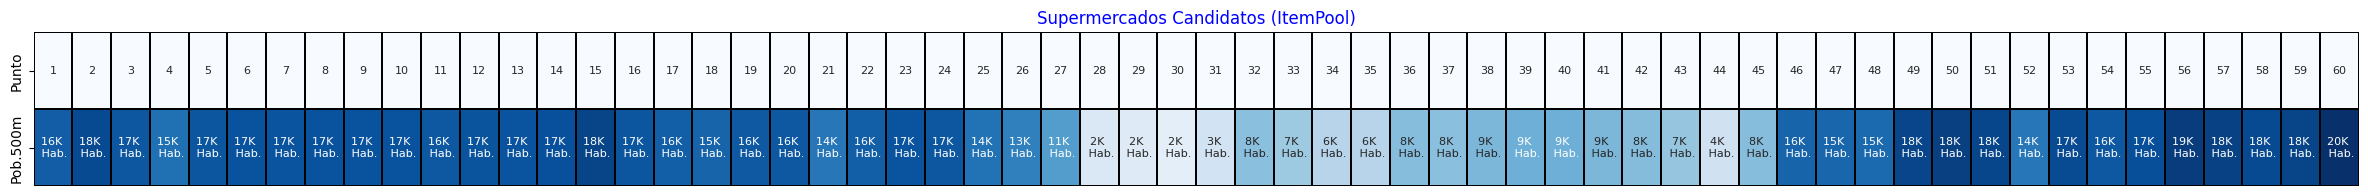

In [241]:
### Función para imprimir la población ###
def imprime_poblacion(data, titulo = 'Item pool'):
  num_items  = len(data)
  pool, annt = {}, {}
  pool[0] = [0                          for j in range(num_items)]
  pool[1] = [data[j].poblacion500m/1000 for j in range(num_items)]
  annt[0] = [f'{j+1}'                                           for j in range(num_items)]
  annt[1] = [str(int((data[j].poblacion500m/1000)))+'K \n Hab.' for j in range(num_items)]
  df1 = pd.DataFrame.from_dict(pool, orient = "index")
  df2 = pd.DataFrame.from_dict(annt, orient = "index")
  fig, ax        = plt.subplots()
  sns.heatmap(     data         = df1,
                   annot        = df2,
                   fmt          = "",
                   ax           = ax,
                   xticklabels  = False,
                   yticklabels  = ['Punto','Pob.500m'],
                   cbar         = False,
                   annot_kws    = {"fontsize": 8},
                   linewidths   = 0.3,
                   linecolor    = 'black',
                   cmap         = "Blues")
  fig.set_size_inches(w=30,h=2)
  ax.set_title(titulo, fontdict = {'fontsize': 12,'color': 'blue'})
  ax.set_yticklabels(ax.get_yticklabels(), rotation=90)
  fig.show()
  return fig, ax
imprime_poblacion(data = ItemPool,titulo = 'Supermercados Candidatos (ItemPool)')

In [242]:
ItemPool[0].poblacion500m, ItemPool[0].longitud, ItemPool[0].latitud , ItemPool[0]

(16500, -77.06496, -12.04861, <__main__.Item at 0x7a78a77f6c80>)

In [243]:
def graficar_poligonos(poligonos, ax):
    poligonos.plot(ax         = ax,
                   color      = (59/255, 111/255, 194/255),
                   alpha      = 0.5,  # saturación
                   edgecolor  = 'gray',
                   figsize    = (20,20),
                   linewidth  = 1,      # tamaño de línea
                   cmap       = None ) #'Blues'
    # leyenda 1Km.
    dist_km  = 1
    dist_deg = dist_km / 111.32
    lat, lon = -12.125, -77.13
    lats     = [lat, lat]
    lons     = [lon , lon + dist_deg ]
    plt.plot(lons, lats, marker='o', markersize = 3 )
    plt.text(-77.13, -12.12,  '1 Km', fontsize=8 , color='red')
    return

In [244]:
def graficar_supermercados(supermercados, ax):
    supermercados.plot(ax         = ax    ,
                       color      = 'red' ,
                       markersize = 40    ,
                       alpha      = 0.5   ,
                       cmap       = None  ,
                       marker     = '^'    )
    return

In [323]:
def mapa(ItemPool,titulo):
    poligonos        = gpd.read_file   (ARCHIVO_MAPA_DISTRITOS)
    x = [ItemPool[i].longitud for i in range(len(ItemPool)) ]
    y = [ItemPool[i].latitud  for i in range(len(ItemPool)) ]
    df_items = pd.DataFrame({'Latitud':y,'Longitud':x})
    df_supermercados = gpd.GeoDataFrame(data     = df_items,
                                        geometry = gpd.points_from_xy(x,y),
                                        crs      = "EPSG:4326"              )
    fig, ax               = plt.subplots(figsize = (14,14))
    plt.xlim(-77.15, -76.88)
    plt.ylim(-12.14, -12.02)
    plt.title(titulo)
    graficar_poligonos    (poligonos       , ax)
    graficar_supermercados(df_supermercados, ax)
    return

In [246]:
def graficar_id(df_id, ax, supermercados):
    for i in range(len(supermercados)):
        ax.text(supermercados['Longitud'][i],
                supermercados['Latitud' ][i],
                df_id[i],
                fontsize=12, ha='left', va='bottom')

In [325]:
def mapa_resultado(ItemPool, cromosoma, titulo):
    poligonos        = gpd.read_file   (ARCHIVO_MAPA_DISTRITOS)
    x     = [ItemPool[i].longitud       for i in cromosoma]
    y     = [ItemPool[i].latitud        for i in cromosoma]
    df_id = [i                          for i in cromosoma]
    df_items = pd.DataFrame({'Latitud':y,'Longitud':x})
    df_supermercados = gpd.GeoDataFrame(data     = df_items,
                                        geometry = gpd.points_from_xy(x,y),
                                        crs      = "EPSG:4326"              )
    fig, ax               = plt.subplots(figsize = (14,14))
    plt.title(titulo)
    plt.xlim(-77.15, -76.88)
    plt.ylim(-12.14, -12.02)
    graficar_poligonos    (poligonos       , ax)
    graficar_supermercados(df_supermercados, ax)
    graficar_id           (df_id           , ax, df_supermercados)
    return

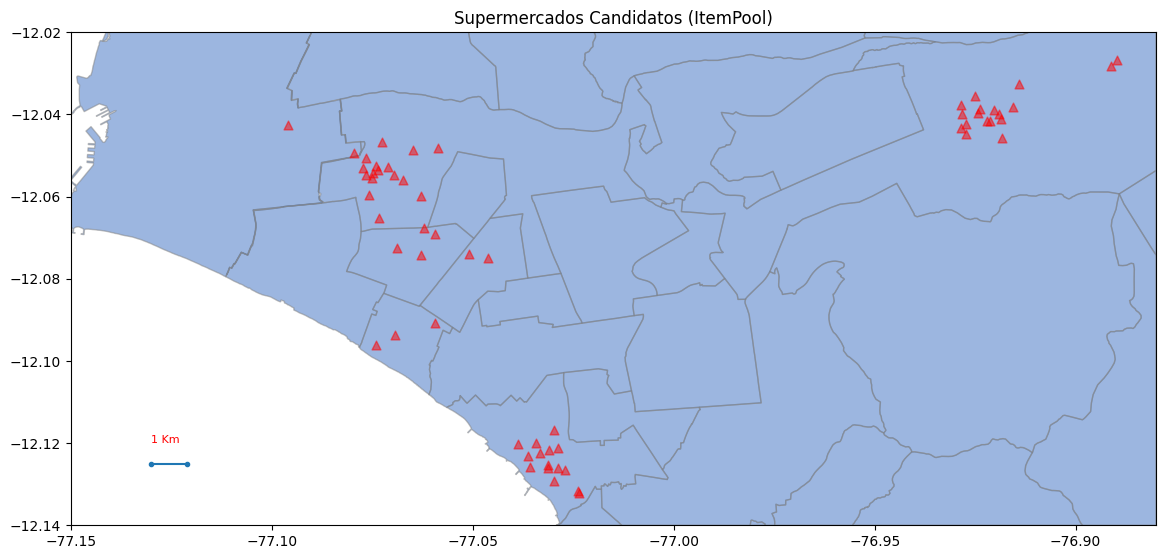

In [324]:
mapa(ItemPool,'Supermercados Candidatos (ItemPool)')

### 4.4 Población inicial

In [249]:
import random
## GENERA POBLACIÓN INICIAL MONO-OBJETIVO Y MULTIOBJETIVO
def genera_poblacion_inicial():
    poblacion_inicial = init_population( MAX_POP_SIZE, CHROMOSOME_SIZE, candidatos )
    poblacion_mono    = deepcopy(poblacion_inicial)
    poblacion_mult    = deepcopy(poblacion_inicial)
    evaluate_population_mono(poblacion_mono, ItemPool, MIN_DISTANCIA)
    evaluate_population_mult(poblacion_mult, ItemPool, MIN_DISTANCIA)
    return poblacion_inicial, poblacion_mono , poblacion_mult
poblacion_inicial, poblacion_mono, poblacion_mult = genera_poblacion_inicial()

In [250]:
# Visualizar los cromosomas de la población
for i in range(len(poblacion_inicial)):
    print('Individuo [',i,']: Fitness = ', poblacion_inicial[i].fitness ,  'Cromosoma =',poblacion_inicial[i].chromosome)

Individuo [ 0 ]: Fitness =  -1 Cromosoma = [22  3 10 59 41 44 49 27 26 54]
Individuo [ 1 ]: Fitness =  -1 Cromosoma = [49 26 37  5 19 23 29  3 27 59]
Individuo [ 2 ]: Fitness =  -1 Cromosoma = [49 34 11 22 26 59 15 19 29 14]
Individuo [ 3 ]: Fitness =  -1 Cromosoma = [20  2 26 15  5 58 31 38 27 47]
Individuo [ 4 ]: Fitness =  -1 Cromosoma = [49  6 19 37  3 30 25 28 14 24]
Individuo [ 5 ]: Fitness =  -1 Cromosoma = [21 37 49 30 42  1 28 24 17 16]
Individuo [ 6 ]: Fitness =  -1 Cromosoma = [43 17 25 50 22 59 27 15 13  2]
Individuo [ 7 ]: Fitness =  -1 Cromosoma = [53 27 29 11 42 26 24 10 20 14]
Individuo [ 8 ]: Fitness =  -1 Cromosoma = [34  7 57 28 18 25 47 24 15 54]
Individuo [ 9 ]: Fitness =  -1 Cromosoma = [10 35 46  2 23 55 26 19 14 27]
Individuo [ 10 ]: Fitness =  -1 Cromosoma = [53 10 24  1 21 26 15 28 30 41]
Individuo [ 11 ]: Fitness =  -1 Cromosoma = [52 27 15  9 46 32 42 22 25 14]
Individuo [ 12 ]: Fitness =  -1 Cromosoma = [43 21  4 52 40 22 46  3 15 18]
Individuo [ 13 ]: Fitn

In [251]:
# Validar que se cumpla el lìmite de la distancia menor a 1 Km.
i=6
cromosoma       = poblacion_inicial[i].chromosome
arreglo, minimo = distancias_cromosoma(cromosoma,ItemPool)
print('Cromosoma[',i,']: ',cromosoma)
print('Distancias entre pares de puntos: \n',arreglo)
print('La menor distancia es: ', minimo, ' Km.')

Cromosoma[ 6 ]:  [43 17 25 50 22 59 27 15 13  2]
Distancias entre pares de puntos: 
 [[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [16.25  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [17.29  4.18  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [15.17  8.67  5.48  0.    0.    0.    0.    0.    0.    0.  ]
 [14.77  2.66  2.97  6.15  0.    0.    0.    0.    0.    0.  ]
 [14.47  7.86  5.01  1.03  5.27  0.    0.    0.    0.    0.  ]
 [ 3.78 19.62 20.94 18.94 18.34 18.25  0.    0.    0.    0.  ]
 [15.27  1.28  5.18  9.11  2.97  8.22 18.56  0.    0.    0.  ]
 [17.24  1.19  4.84  9.7   3.81  8.92 20.54  1.98  0.    0.  ]
 [17.01  1.21  3.18  8.14  2.62  7.41 20.46  2.47  1.66  0.  ]]
La menor distancia es:  1.03  Km.


### 4.5 Graficando la población inicial

In [252]:
poblacion_mono[0].chromosome

array([22,  3, 10, 59, 41, 44, 49, 27, 26, 54])

(<Figure size 1000x3000 with 1 Axes>,
 <Axes: title={'center': 'Población inicial'}, xlabel='Genes', ylabel='Individuo'>)

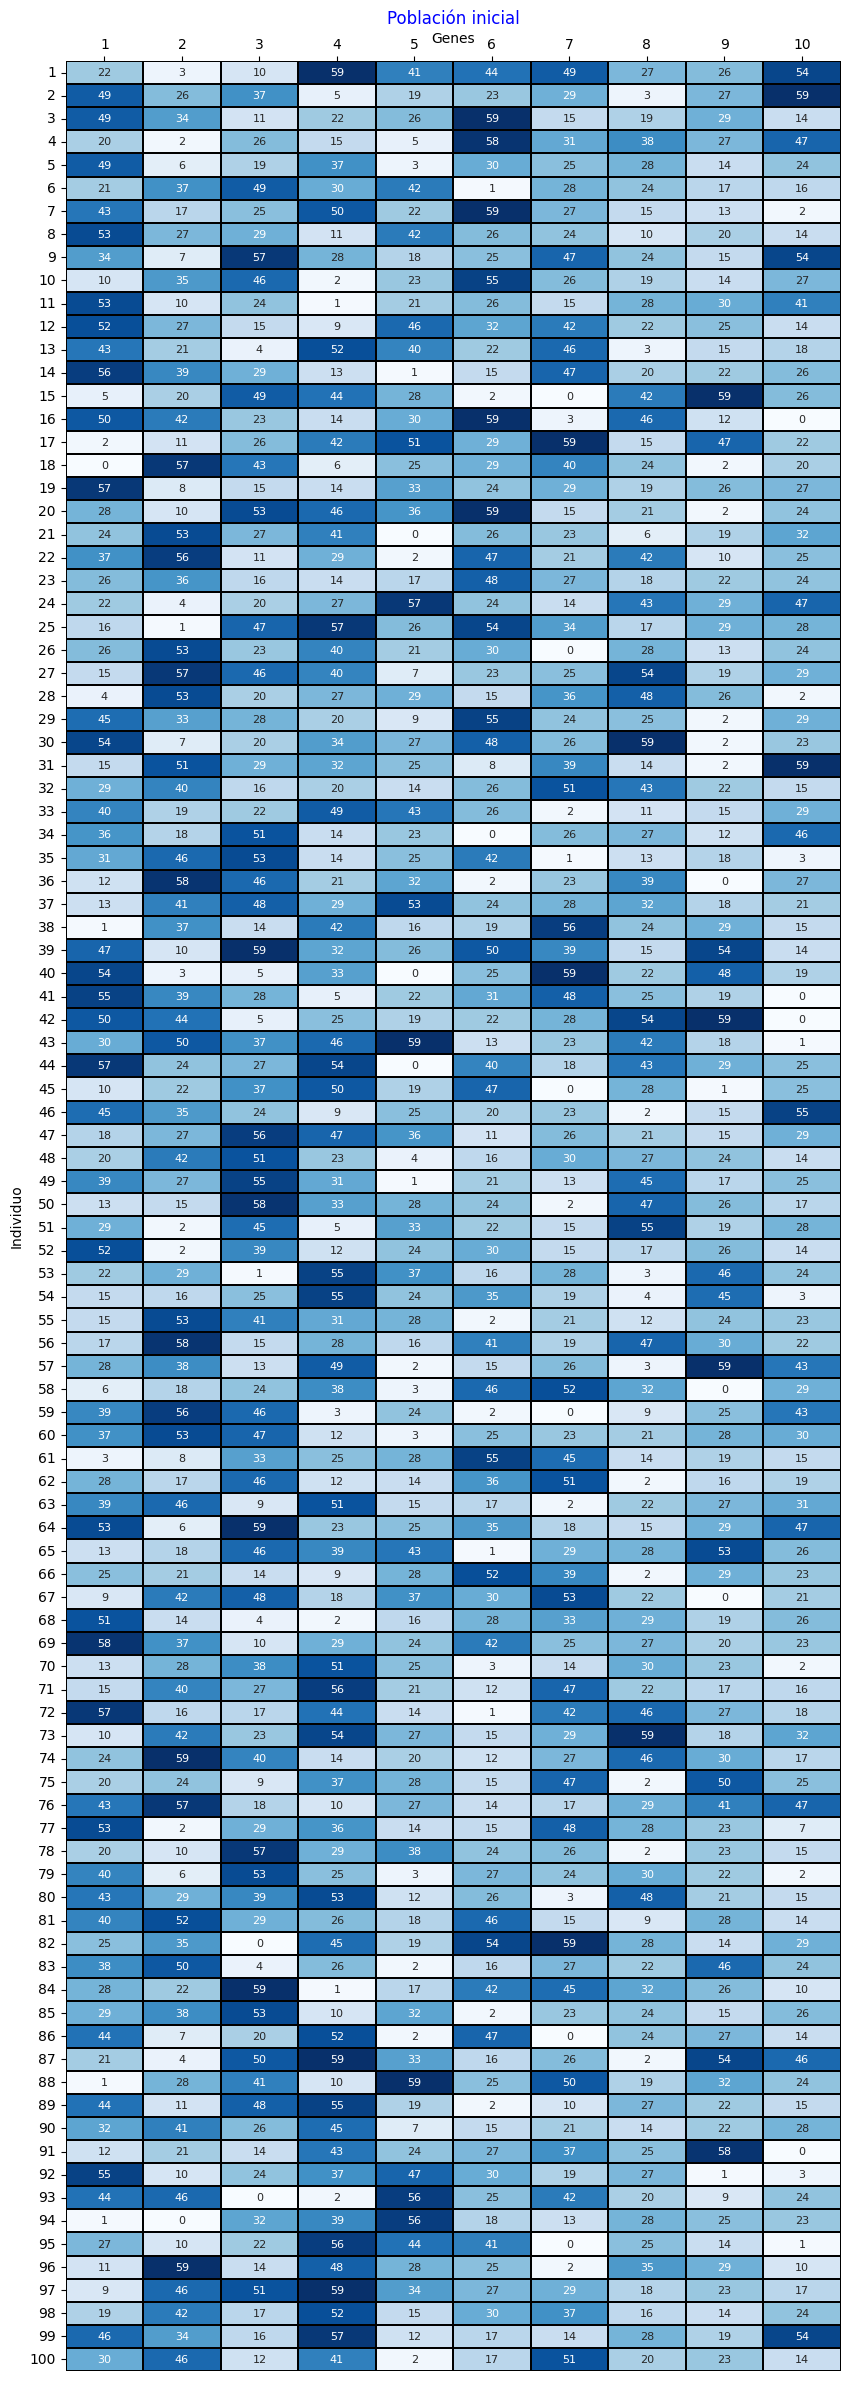

In [253]:
### Función para imprimir la población ###
def imprime_poblacion(poblacion, titulo = 'Población inicial'):
  num_genes      = len(poblacion[0].chromosome)
  num_cromosomas = len(poblacion)
  cromosoma      = np.zeros((num_cromosomas,num_genes), dtype=int)
  cromosoma      = [poblacion[i].chromosome.astype(int) for i in range(num_cromosomas)]
  fig, ax        = plt.subplots()
  sns.heatmap(     data         = cromosoma,
                   annot        = True,
                   fmt          = "",
                   ax           = ax,
                   xticklabels  = [f'{i+1}' for i in range(num_genes)],
                   yticklabels  = [f'{k+1}' for k in range(num_cromosomas)],
                   cbar         = False,
                   annot_kws    = {"fontsize": 8},
                   linewidths   = 0.3,
                   linecolor    = 'black',
                   cmap         = "Blues")
  fig.set_size_inches(w=10,h=30)
  ax.set_title(titulo, fontdict = {'fontsize': 12,'color': 'blue'})
  ax.set_ylabel('Individuo')
  ax.set_xlabel('Genes')
  ax.xaxis.tick_top()
  ax.xaxis.label_position = 'top'
  fig.show()
  return fig, ax
imprime_poblacion(poblacion = poblacion_mono, titulo = 'Población inicial') #  \n \n  Genes')

### 4.6 Graficando el fitness de la población inicial

In [254]:
def mostrar_fitness(poblacion_mono, poblacion_mult):
    df_mono = [poblacion_mono[i].fitness    for i in range(len(poblacion_mono)) ]
    df_mult = [poblacion_mult[i].fitness    for i in range(len(poblacion_mult)) ]
    df_fitness_mono = pd.DataFrame(df_mono, columns = ['Fitness-Valor (mono-objetivo)'])
    df_fitness_mult = pd.DataFrame(df_mult, columns = ['Fitness-Poblacion (multiobjetivo)', 'Fitness-Distancias (multiobjetivo)'])
    df_total        = df_fitness_mono.join(df_fitness_mult)
    return df_fitness_mono, df_fitness_mult , df_total
df_fitness_mono, df_fitness_mult, df_total = mostrar_fitness(poblacion_mono, poblacion_mult)
df_total.head(5)

,Fitness-Valor (mono-objetivo),Fitness-Poblacion (multiobjetivo),Fitness-Distancias (multiobjetivo)
0,0.899788,137300.0,469.52
1,0.869281,130700.0,466.95
2,0.903175,145350.0,413.44
3,0.886622,132850.0,479.32
4,0.878288,130850.0,479.77


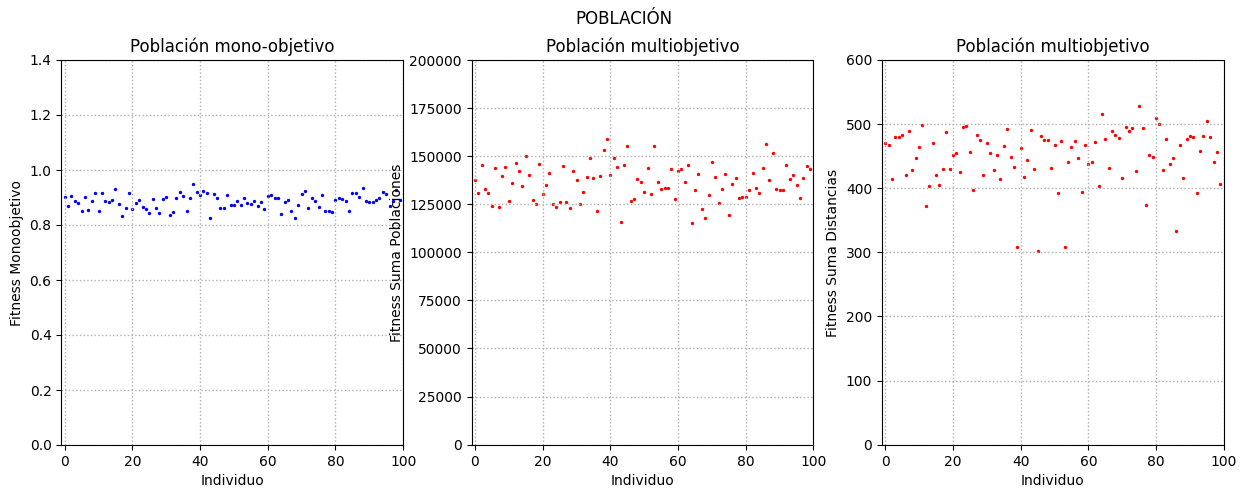

In [255]:
def graficar_poblaciones(poblacion0, poblacion1):
    y0 = df_fitness_mono['Fitness-Valor (mono-objetivo)']
    x0 = [i for i in range(len(poblacion0))]

    y1 = df_fitness_mult['Fitness-Poblacion (multiobjetivo)']
    x1 = [i for i in range(len(poblacion1))]

    y2 = df_fitness_mult['Fitness-Distancias (multiobjetivo)']
    x2 = [i for i in range(len(poblacion1))]

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('POBLACIÓN')

    configurar_grafica(axs[0], 'Población mono-objetivo','Individuo','Fitness Monoobjetivo')
    axs[0].scatter(x0, y0, color='blue', s=2)

    configurar_grafica(axs[1], 'Población multiobjetivo','Individuo','Fitness Suma Poblaciones')
    axs[1].scatter(x1, y1, color='red', s=2)

    configurar_grafica(axs[2], 'Población multiobjetivo','Individuo','Fitness Suma Distancias')
    axs[2].scatter(x2, y2, color='red', s=2)

    axs[0].set_xlim(-1,len(poblacion0))
    axs[0].set_ylim(0,1.4)

    axs[1].set_xlim(-1,len(poblacion1))
    axs[1].set_ylim(0, 200000)

    axs[2].set_xlim(-1,len(poblacion1))
    axs[2].set_ylim(0, 600)

    fig.show()
graficar_poblaciones(poblacion0 = df_fitness_mono, poblacion1 = df_fitness_mult)

Gráfica de la poblacion multiobjetivo, una gráfica vista como maximizacion en los dos ejes (valor y ligereza), y otra gráfica vista como maximización de valor y minimización de peso.

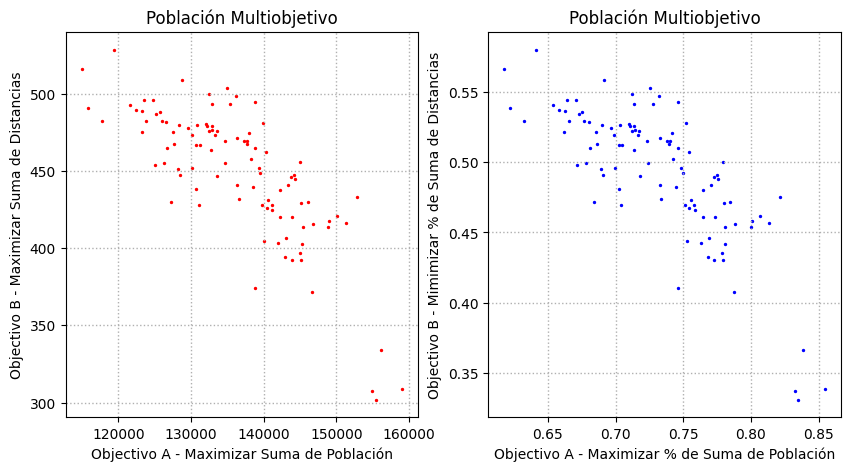

In [256]:
graficar(poblacion0 = poblacion_mult,
                      title0  ='Población Multiobjetivo',
                      xlabel0 = 'Objectivo A - Maximizar Suma de Población' ,
                      ylabel0 = 'Objectivo B - Maximizar Suma de Distancias',
                      color0  = 'red' ,
         poblacion1 = poblacion_mult,
                      title1  = 'Población Multiobjetivo',
                      xlabel1 = 'Objectivo A - Maximizar % de Suma de Población',
                      ylabel1 = 'Objectivo B - Mimimizar % de Suma de Distancias',
                      color1  = 'blue')

(<Figure size 1500x50 with 1 Axes>, <Axes: title={'center': 'Individuo 7'}>)

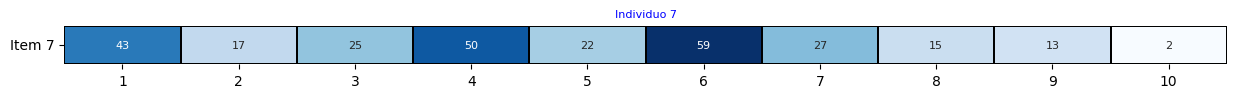

In [257]:
### Función para imprimir un individuo ###
def imprime_individuo(individuo, k, titulo = ''):
  df_valor     = np.zeros(len(individuo), dtype=int)
  df_cromosoma = np.transpose(pd.DataFrame(individuo))
  for j in range(len(individuo)): df_valor[j] = int(individuo[j])
  df_valor     = np.transpose(pd.DataFrame(df_valor))
  fig, ax      = plt.subplots()
  sns.heatmap(   df_cromosoma,
                 annot        = df_valor,
                 fmt          = "",
                 ax           = ax,
                 xticklabels  = [f'{i+1}' for i in range(len(individuo))],
                 yticklabels  = [f'Item {k+1}'],
                 cbar         = False,
                 annot_kws    = {"fontsize": 8},
                 linewidths   = 0.2,
                 linecolor    = 'black',
                 cmap         = "Blues")
  fig.set_size_inches(w=15, h=0.5)
  ax.set_title(titulo, fontdict = {'fontsize': 8,'color': 'blue'})
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
  fig.show()
  return fig, ax
k=6
imprime_individuo(individuo = poblacion_mono[k].chromosome, k = k, titulo = f'Individuo {k+1}')

## 5 Algoritmo Genético Mono-objetivo

Ciclo: 0


100%|██████████| 150/150 [06:09<00:00,  2.46s/it]


Ciclo: 1


100%|██████████| 150/150 [06:09<00:00,  2.46s/it]


Ciclo: 2


100%|██████████| 150/150 [06:10<00:00,  2.47s/it]


Ciclo: 3


100%|██████████| 150/150 [06:07<00:00,  2.45s/it]


Ciclo: 4


100%|██████████| 150/150 [06:09<00:00,  2.46s/it]


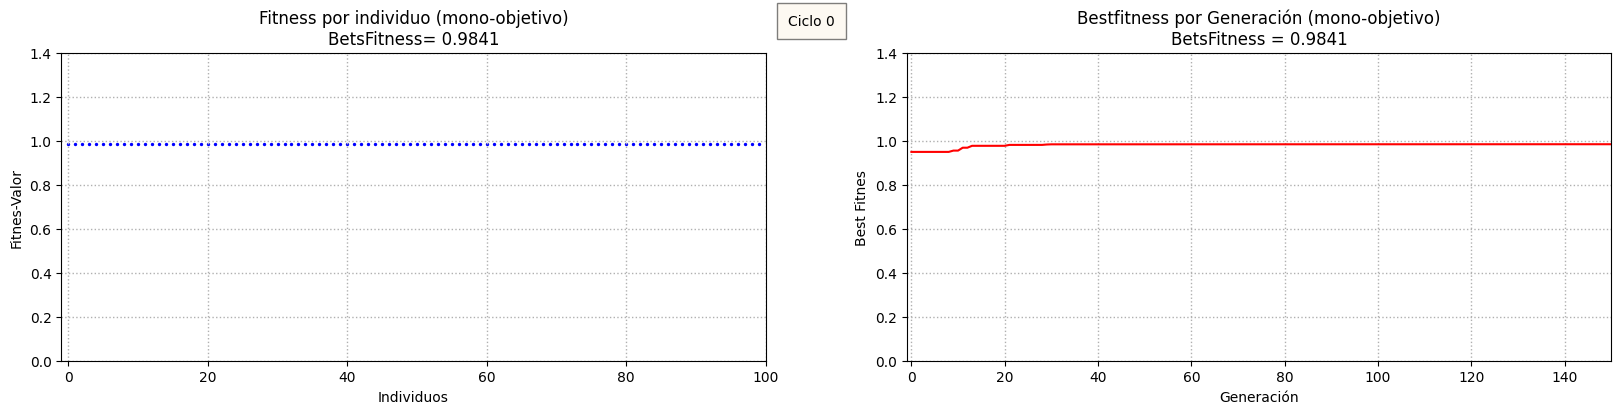

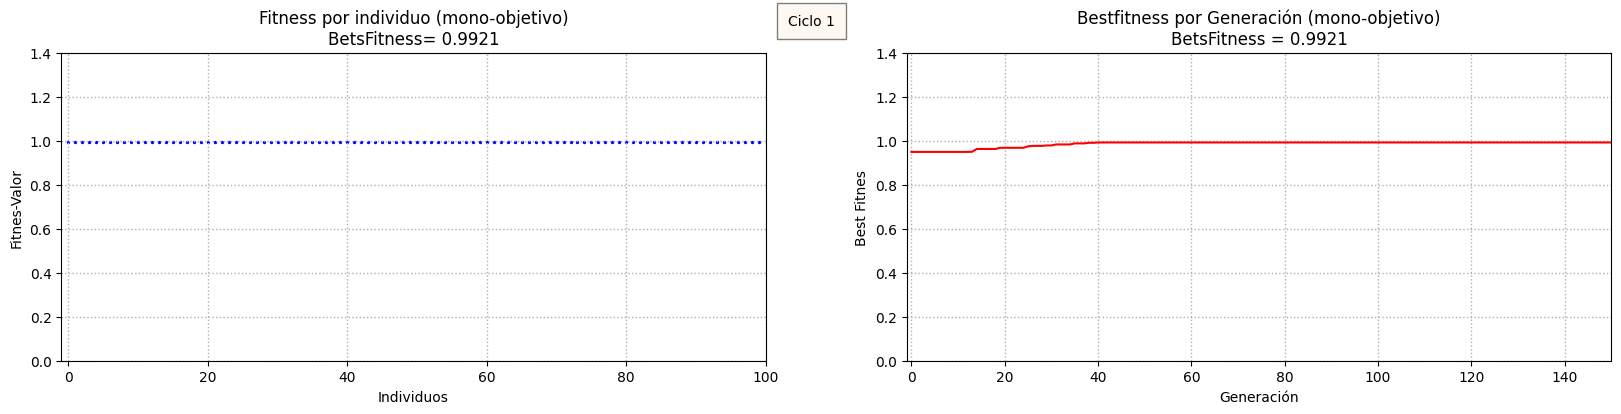

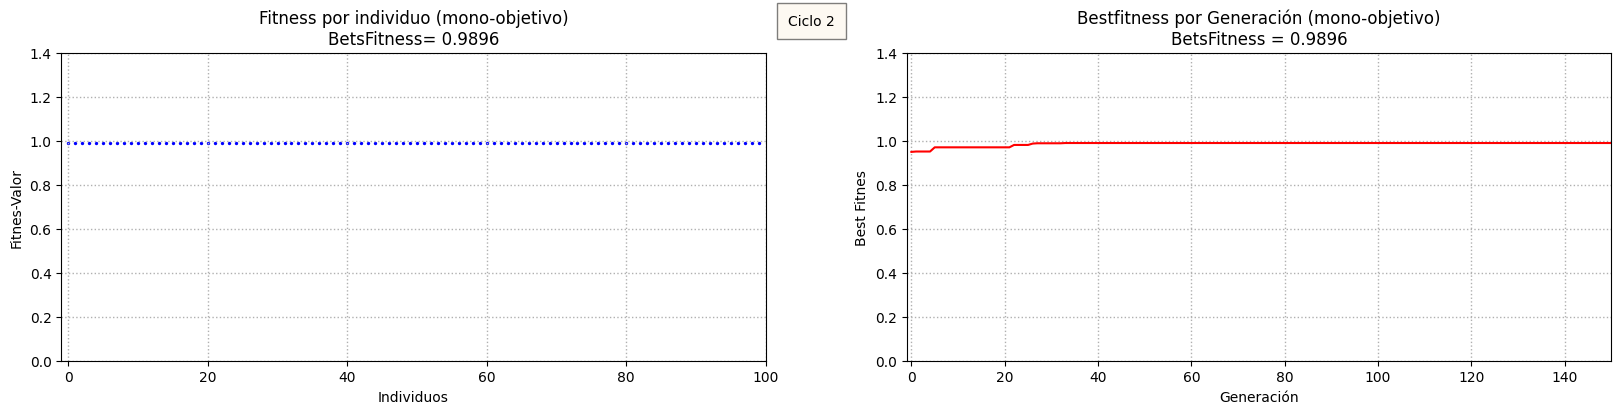

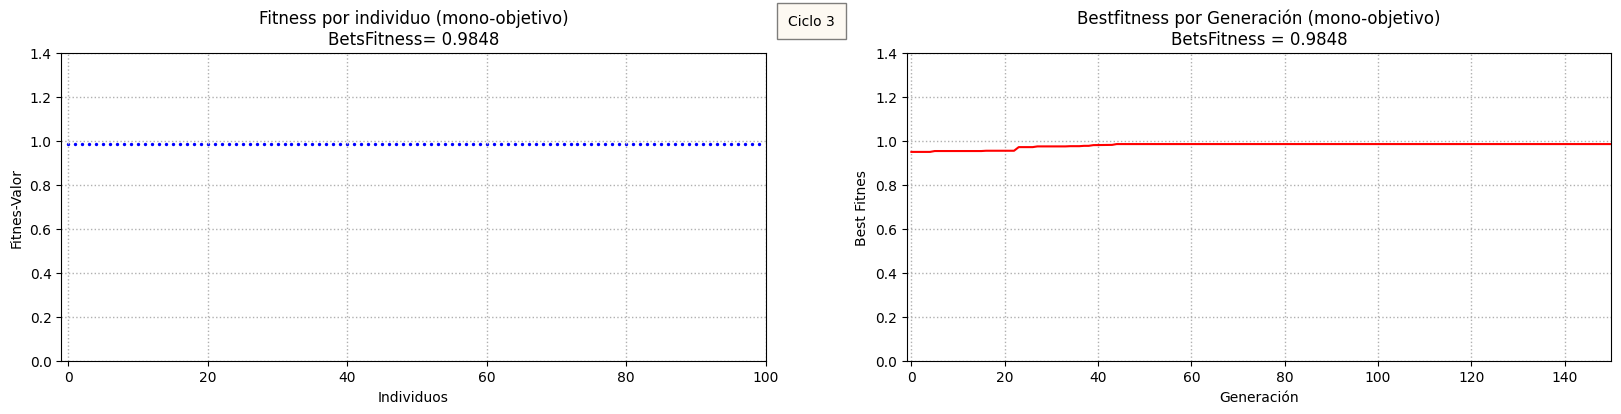

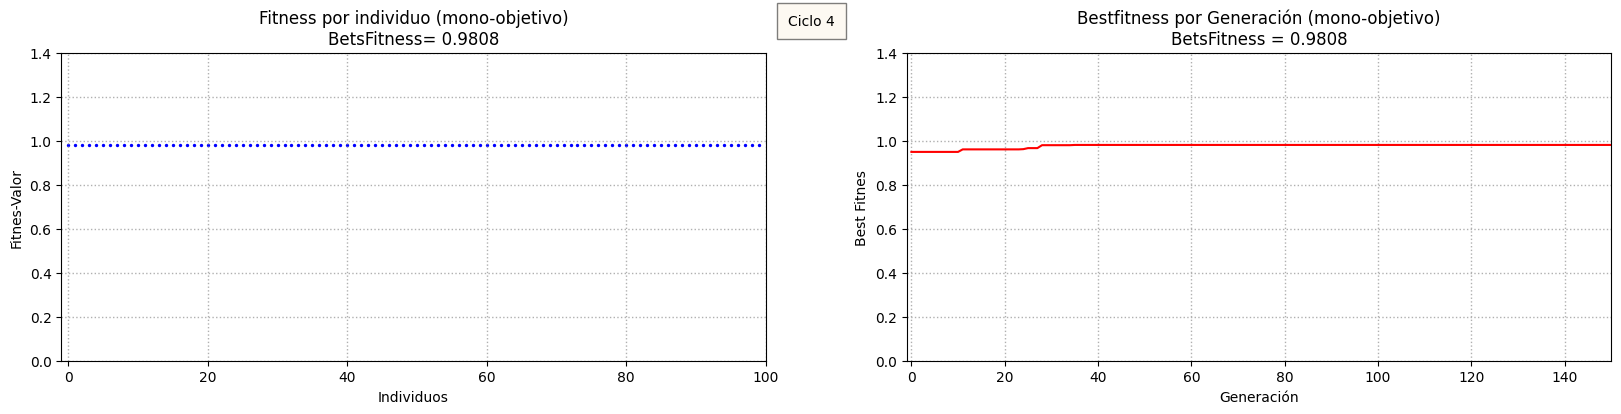

In [454]:
for i in range(CICLOS):
  print('Ciclo:', i)
  best_mono = []
  for tipo_pmut in [PMUT[1]]:
    #==========================================================================
    ## ETAPA 1: POBLACIÓN INICIAL
    #==========================================================================
    P_mono = deepcopy(poblacion_inicial)    # población mono-objetivo
    #==========================================================================
    ## ETAPA 2: EVALUAR EL FITNESS
    #==========================================================================
    evaluate_population_mono(P_mono, ItemPool, MIN_DISTANCIA)
    #==========================================================================
    ## CITERIO DE PARADA: Número máximo de generaciones
    #==========================================================================
    ibest = busca_indice_bestfitness(P_mono)
    bestfitness = [P_mono[ibest].fitness]
    with tqdm(total=GENERATIONS) as barra:
        for g in range(GENERATIONS):
          #==========================================================================
          ## ETAPA 3: SELECCIONAR INDIVIDUOS MÁS APTOS
          ## ETAPA 4: CRUZAMIENTO
          ## ETAPA 5: MUTACIÓN
          #==========================================================================
          padres_mono = deepcopy(P_mono)
          #hijos_mono  = build_offspring_population(P_mono, "uniform", "swap", tipo_pmut)
          hijos_mono  = build_offspring_population(P_mono, "orderpermutation", "swap", tipo_pmut)
          #==========================================================================
          ## ETAPA: EVALUAR EL FITNESS
          #==========================================================================
          evaluate_population_mono(hijos_mono, ItemPool, MIN_DISTANCIA )
          #======================================================================
          ## ETAPA 6: SELECCIÓN DE SOBREVIVIENTES
          #======================================================================
          P_mono = select_survivors_ranking(padres_mono,hijos_mono,POP_SIZE)
          ibest = busca_indice_bestfitness(P_mono)
          bestfitness.append(P_mono[ibest].fitness)
          #======================================================================
          ## GRAFICAR RESULTADOS
          #======================================================================
          ##graficar_poblacionx1(P_mono,g+1,bestfitness)
          #if (g+1)%50 == 0:graficar_poblacionx3(P_mono,bestfitness,bestweights,pareto,P_mult, g+1)
          barra.update(1)
          best_mono.append(P_mono[ibest])
    graficar_poblacionx3(P_mono,bestfitness,g+1, tipo_pmut,i)
    del padres_mono
    del hijos_mono
    del bestfitness
    bestfitness_mono = P_mono[0]

In [259]:
bestfitness_mono.fitness, bestfitness_mono.chromosome

(0.9491781004267131, array([47, 10, 59, 32, 26, 50, 39, 15, 54, 14]))

In [378]:
best_mono[0].chromosome

array([47, 10, 59, 32, 26, 50, 39, 15, 54, 14])

## 6 Algoritmo Genético Multiobjetivo

Ciclo: 0


100%|██████████| 150/150 [06:26<00:00,  2.58s/it]


Ciclo: 1


100%|██████████| 150/150 [06:18<00:00,  2.52s/it]


Ciclo: 2


100%|██████████| 150/150 [06:20<00:00,  2.53s/it]


Ciclo: 3


100%|██████████| 150/150 [06:19<00:00,  2.53s/it]


Ciclo: 4


100%|██████████| 150/150 [06:18<00:00,  2.52s/it]


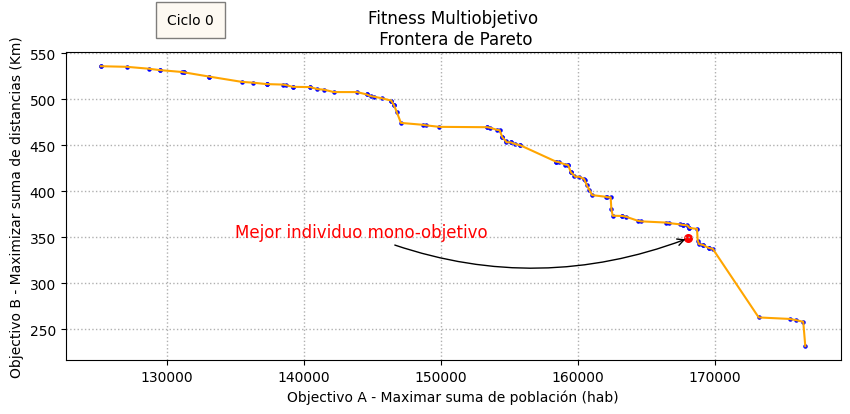

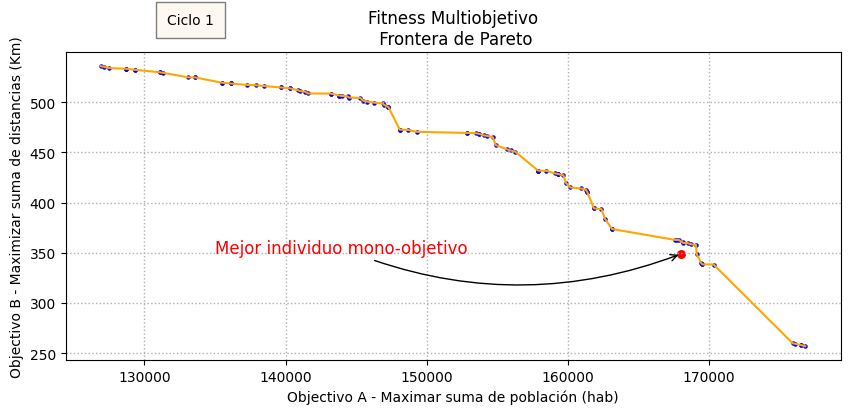

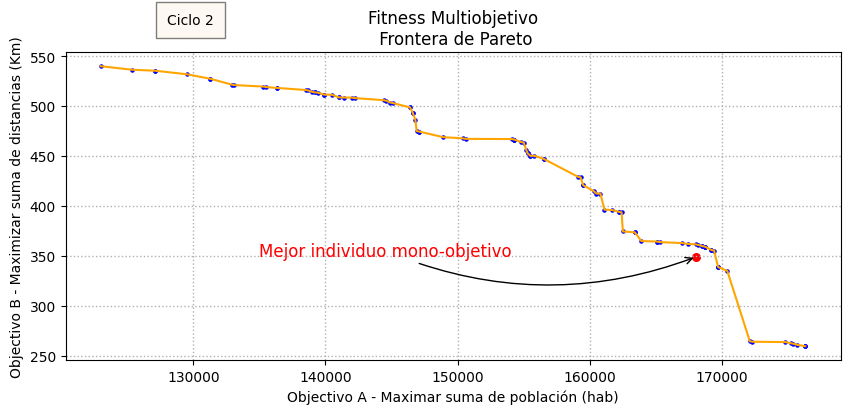

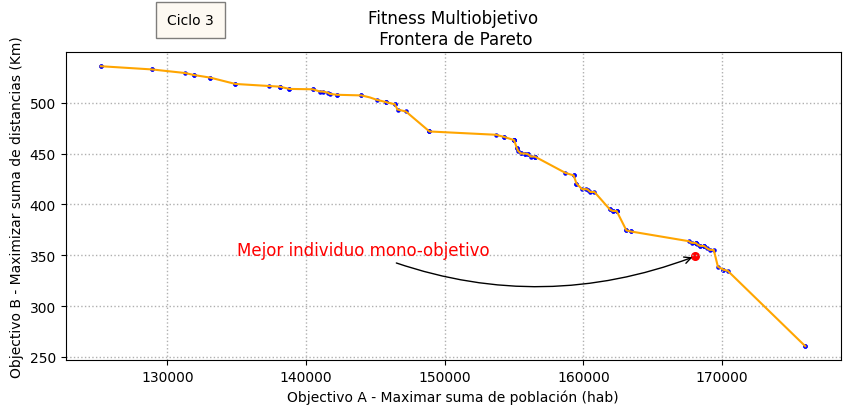

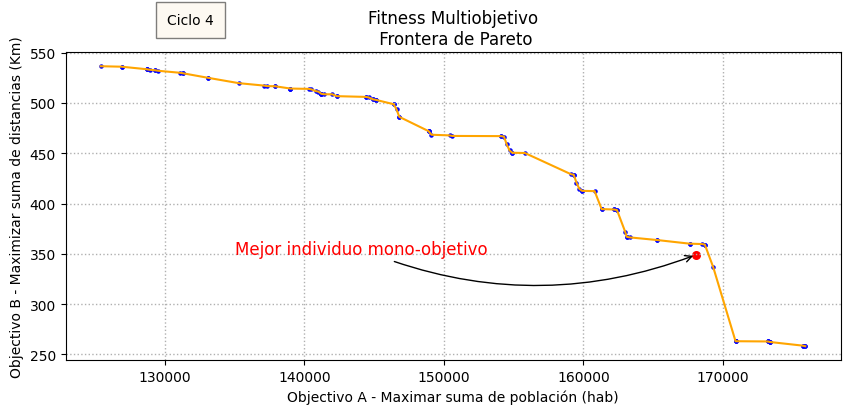

In [455]:
for i in range(CICLOS):
  print('Ciclo:', i)
  best_mult = []
  for tipo_pmut in [PMUT[1]]:
    #==========================================================================
    ## ETAPA 1: POBLACIÓN INICIAL
    #==========================================================================
    P_mult = deepcopy(poblacion_inicial)    # población multiobjetivo
    #==========================================================================
    ## ETAPA 2: EVALUAR EL FITNESS
    #==========================================================================
    evaluate_population_mult(P_mult, ItemPool, MIN_DISTANCIA)
    #==========================================================================
    ## CITERIO DE PARADA: Número máximo de generaciones
    #==========================================================================
    with tqdm(total=GENERATIONS) as barra:
      for g in range(GENERATIONS):
        #==========================================================================
        ## ETAPA 3: SELECCIONAR INDIVIDUOS MÁS APTOS
        ## ETAPA 4: CRUZAMIENTO
        ## ETAPA 5: MUTACIÓN
        #==========================================================================
        padres_mult = deepcopy(P_mult)
        hijos_mult  = build_offspring_population(P_mult, "orderpermutation", "swap", tipo_pmut)
        #==========================================================================
        ## ETAPA: EVALUAR EL FITNESS
        #==========================================================================
        evaluate_population_mult(hijos_mult, ItemPool, MIN_DISTANCIA)
        #======================================================================
        ## ETAPA 6: SELECCIÓN DE SOBREVIVIENTES
        #======================================================================
        P_mult.extend(hijos_mult)
        pareto = get_paretofront_population(P_mult)
        P_mult = build_next_population(P_mult, MIN_POP_SIZE, MAX_POP_SIZE)
        #======================================================================
        ## GRAFICAR RESULTADOS
        #======================================================================
        #graficar_poblacionx1(P_mono,g+1,bestfitness)
        #if (g+1)%50 == 0:graficar_poblacionx3(P_mono,bestfitness,bestweights,pareto,P_mult, g+1)
        barra.update(1)
        best_mult.append(pareto)
      graficar_poblacionx4(bestfitness_mono, pareto,P_mult, g+1, tipo_pmut,i)
    del padres_mult
    del hijos_mult
    del pareto
pareto_front_population = get_paretofront_population(P_mult)

## 7 Datos registrados

### Mejores individuos de las ejecuciones del algoritmo mono-objetivo

In [405]:
lista_c = [best_mono[i].chromosome for i in range(len(best_mono))]
lista_f = [best_mono[i].fitness    for i in range(len(best_mono))]
lista_p = [suma_poblaciones(ItemPool, best_mono[i].chromosome) for i in range(len(best_mono))]
lista_d = [suma_distancias (ItemPool, best_mono[i].chromosome) for i in range(len(best_mono))]
data = {'Fitness'        : lista_f,
        'Suma poblacion' : lista_p,
        'Suma distancias': lista_d,
        'Cromosoma'      : lista_c}
df_best_mono_objetivo = pd.DataFrame(data)
print('Mejores individuos de cada ejecución mono-objetivo:')
df_best_mono_objetivo

Mejores individuos de cada ejeecución:


,Fitness,Suma poblacion,Suma distancias,Cromosoma
0,0.949178,152900,433.26,"[47, 10, 59, 32, 26, 50, 39, 15, 54, 14]"
1,0.949178,152900,433.26,"[47, 10, 59, 32, 26, 50, 39, 15, 54, 14]"
2,0.949178,152900,433.26,"[47, 10, 59, 32, 26, 50, 39, 15, 54, 14]"


### Mejores individuos de las ejecuciones del algoritmo multiobjetivo

In [450]:
lista_i, lista_c, lista_p, lista_d = [], [], [], []
for i in range(len(best_mult)):
   for j in range(len(best_mult[i])):
       lista_i.append(i)
       lista_c.append(best_mult[i][j].chromosome)
       lista_p = suma_poblaciones(ItemPool, best_mult[i][j].chromosome)
       lista_d = suma_distancias (ItemPool, best_mult[i][j].chromosome)
data = {'Ciclo'          : lista_i,
        'Suma poblacion' : lista_p,
        'Suma distancias': lista_d,
        'Cromosoma'      : lista_c}
df_best_mult_objetivo = pd.DataFrame(data)
print('Mejores individuos de cada ejecución multiobjetivo:')
df_best_mult_objetivo

Mejores individuos de cada ejecución multiobjetivo:


,Ciclo,Suma poblacion,Suma distancias,Cromosoma
0,0,146450,436.87,"[52, 27, 15, 9, 46, 32, 42, 22, 25, 14]"
1,0,146450,436.87,"[47, 10, 59, 32, 26, 50, 39, 15, 54, 14]"
2,0,146450,436.87,"[54, 3, 5, 33, 0, 25, 59, 22, 48, 19]"
3,0,146450,436.87,"[55, 39, 28, 5, 22, 31, 48, 25, 19, 0]"
4,0,146450,436.87,"[57, 16, 17, 44, 14, 1, 42, 46, 27, 18]"
5,0,146450,436.87,"[43, 57, 18, 10, 27, 14, 17, 29, 41, 47]"
6,0,146450,436.87,"[40, 52, 29, 26, 18, 46, 15, 9, 28, 14]"
7,0,146450,436.87,"[21, 4, 50, 59, 33, 16, 26, 2, 54, 46]"
8,0,146450,436.87,"[27, 10, 22, 56, 44, 41, 0, 25, 14, 1]"
9,0,146450,436.87,"[11, 59, 14, 48, 28, 25, 2, 35, 29, 10]"


## 8 Comparación de resultados

In [456]:
print('Elementos de la frontera de Pareto:')
for i in range(len(pareto_front_population)):
    print(i, pareto_front_population[i].chromosome)

Elementos de la frontera de Pareto:
0 [14, 50, 42, 54, 22, 1, 37, 59, 15, 27]
1 [59, 54, 10, 47, 37, 1, 50, 27, 15, 14]
2 [46, 59, 10, 30, 15, 50, 54, 1, 27, 14]
3 [59, 10, 37, 54, 1, 50, 22, 15, 27, 14]
4 [10, 14, 37, 1, 50, 29, 59, 42, 27, 47]
5 [54, 21, 16, 59, 15, 25, 50, 4, 47, 14]
6 [10, 42, 37, 21, 54, 1, 59, 15, 50, 14]
7 [22, 59, 54, 1, 42, 14, 50, 15, 37, 27]
8 [1, 59, 37, 10, 22, 54, 46, 50, 15, 14]
9 [54, 21, 16, 59, 15, 25, 50, 4, 47, 14]
10 [10, 59, 37, 1, 25, 42, 47, 50, 27, 14]
11 [10, 50, 59, 30, 42, 1, 37, 14, 27, 46]
12 [10, 59, 37, 27, 25, 47, 50, 1, 15, 14]
13 [42, 10, 37, 1, 50, 46, 59, 15, 27, 14]
14 [1, 59, 37, 10, 27, 54, 46, 50, 42, 14]
15 [37, 46, 1, 54, 59, 10, 25, 50, 14, 15]
16 [37, 30, 46, 59, 25, 10, 1, 27, 50, 14]
17 [54, 10, 37, 21, 1, 59, 15, 50, 27, 14]
18 [27, 10, 37, 47, 50, 1, 59, 43, 29, 14]
19 [47, 30, 54, 10, 1, 59, 50, 37, 27, 14]
20 [14, 21, 59, 10, 22, 1, 50, 47, 15, 54]
21 [54, 10, 37, 50, 27, 47, 30, 1, 15, 14]
22 [10, 42, 54, 37, 59, 50, 

------------------------------------------------------------------------------------------------------------------------ 
 Mejor individuo mono-objetivo 
 Fitness          : 0.98 
 Suma poblacion   : 168,050  habitantes
 Suma distancias  : 349.0  Km.
 ------------------------------------------------------------------------------------------------------------------------
 Un individuo multiobjetivo de la frontera de Pareto 
 Suma poblacion   : 175,900  habitantes
 Suma distancias  : 258.22  Km.
 ------------------------------------------------------------------------------------------------------------------------


(<Figure size 1500x50 with 1 Axes>,
 <Axes: title={'center': 'Mejor individuo multiobjetivo: item 29'}>)

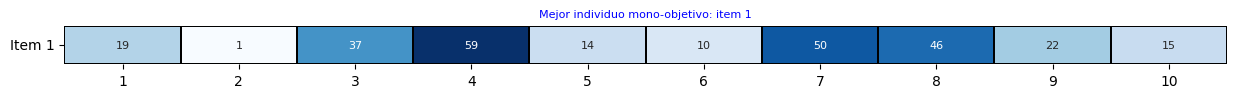

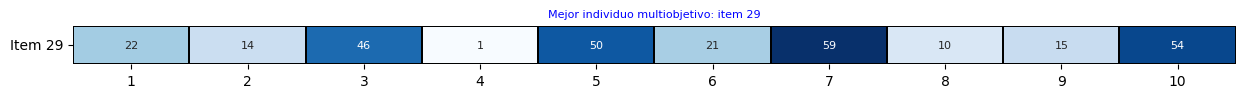

In [457]:
xfitness      = get_fitness_mono(P_mono[0].chromosome, ItemPool, MIN_DISTANCIA)
suma_pob_mono = suma_poblaciones(ItemPool, P_mono[0].chromosome)
suma_dis_mono = suma_distancias (ItemPool, P_mono[0].chromosome)
print('-'*120,'\n','Mejor individuo mono-objetivo','\n',
      'Fitness          :', round(xfitness,2) ,'\n'
      ' Suma poblacion   :', "{:,}".format(int(suma_pob_mono)) ,' habitantes\n',
      'Suma distancias  :', round(suma_dis_mono,2),' Km.\n','-'*120)

a = [pareto_front_population[i].fitness for i in range(len(pareto_front_population))]
max_indice = np.argmax([subarray[0] for subarray in a])
max_fitness = a[max_indice]
indice = next((i for i, x in enumerate(a) if x[0] == max_fitness[0]), None)

#factr = math.sqrt((max_fitness[0]/MAX_POBLACION)**2 + (max_fitness[1]/MAX_DISTANCIA) **2)
print(' Un individuo multiobjetivo de la frontera de Pareto','\n',
      'Suma poblacion   :', "{:,}".format(int(max_fitness[0])) ,' habitantes\n',
      'Suma distancias  :', round(max_fitness[1],2),' Km.\n','-'*120)

k=0
imprime_individuo(individuo = P_mono[k].chromosome, k = 0, titulo = f'Mejor individuo mono-objetivo: item {1}')
imprime_individuo(individuo = pareto_front_population[indice].chromosome, k = indice,
                  titulo = f'Mejor individuo multiobjetivo: item {indice+1}')

In [458]:
def distancia(a,b):
    punto_a = [a.latitud, a.longitud]
    punto_b = [b.latitud, b.longitud]
    distancia = round( geodesic((punto_a[0], punto_a[1]),
                                (punto_b[0], punto_b[1])).kilometers,2)
    return distancia

In [459]:
print(distancia(ItemPool[54],ItemPool[59]))

1.03


Punto         19      1    37     59     14     10     50     46     22     15
Población  16950  18000  9200  20000  18500  16900  18300  15800  17300  17100


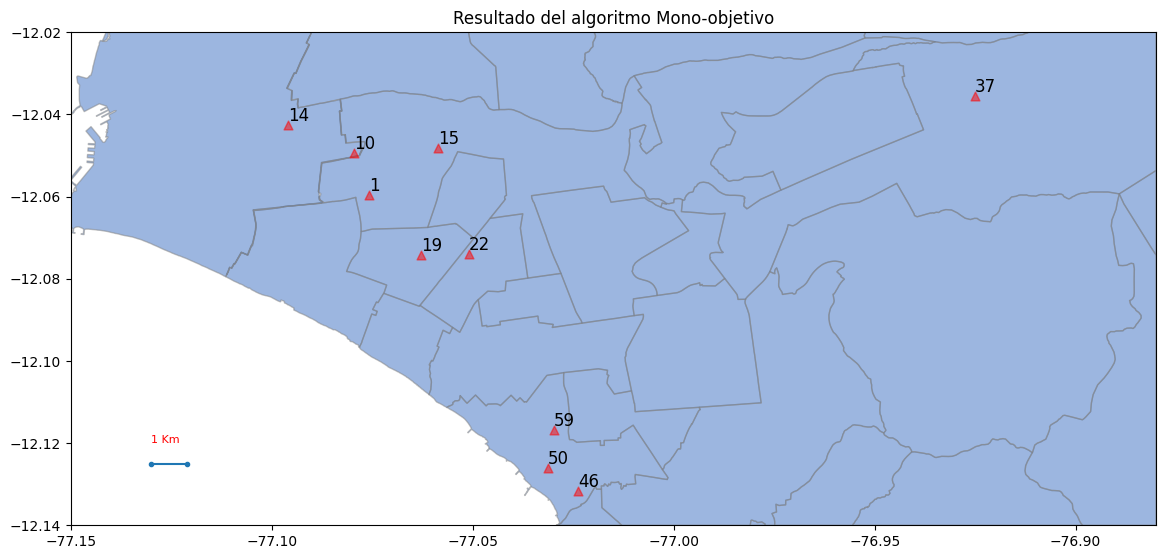

In [460]:
puntos = P_mono[0].chromosome
poblaciones = [ItemPool[i].poblacion500m for i in P_mono[0].chromosome]
df = pd.DataFrame({'Punto': puntos, 'Población': poblaciones})
print(df.transpose().to_string(header=False))
mapa_resultado(ItemPool, P_mono[0].chromosome, 'Resultado del algoritmo Mono-objetivo')

Punto         22     14    46      1     50     21     59     10     15     54
Población  16950  18000  9200  20000  18500  16900  18300  15800  17300  17100


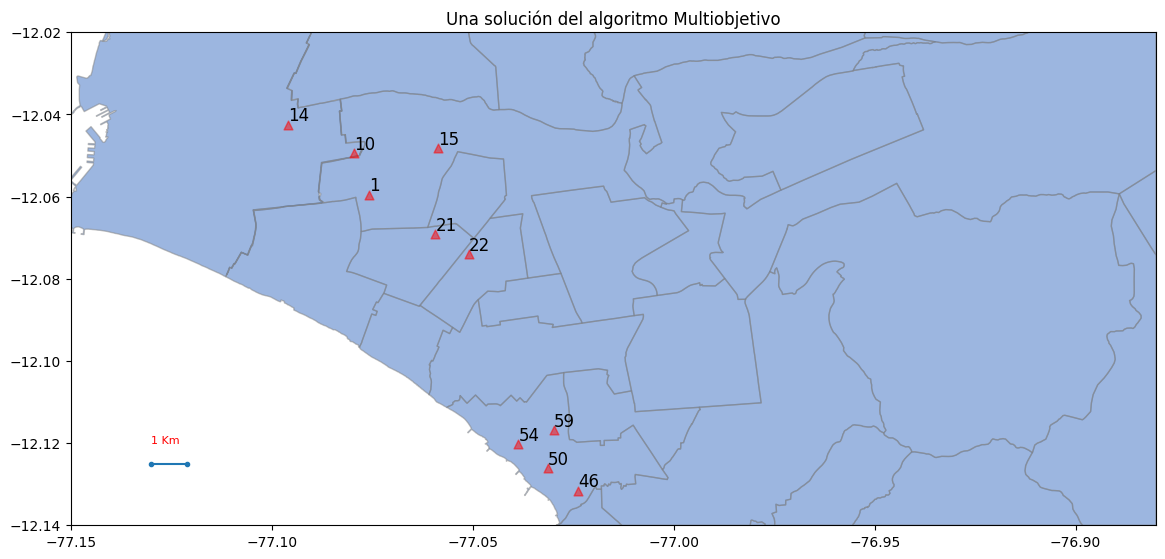

In [461]:
#print("Cromosoma:", pareto_front_population[indice].chromosome)
puntos = pareto_front_population[indice].chromosome
poblaciones = [ItemPool[i].poblacion500m for i in P_mono[0].chromosome]
df = pd.DataFrame({'Punto': puntos, 'Población': poblaciones})
print(df.transpose().to_string(header=False))
mapa_resultado(ItemPool, pareto_front_population[indice].chromosome, 'Una solución del algoritmo Multiobjetivo')